In [22]:
import lalsimulation as ls
import lal
import numpy as np

import matplotlib.pyplot as plt

import math
import time
from scipy.optimize import minimize



# Function Definitions

In [23]:
def get_LIGO_psd(f_low,deltaF,len_wf):

    # Define the frequency series where to put the PSD
    epoch = lal.LIGOTimeGPS(0, 0)

    Sn = lal.CreateREAL8FrequencySeries("psd",epoch,0.,deltaF,lal.StrainUnit,len_wf)

    # Compute the PSD from the given f_low
    ls.SimNoisePSDaLIGOZeroDetHighPowerGWINC(Sn,f_low)
    
    Sn.data.data[0 : int(f_low/deltaF)] = Sn.data.data[int(f_low/deltaF)]
    Sn.data.data[-1] = Sn.data.data[-2]
    
    return Sn

In [24]:
def inner_prod(hlm1_FD, hlm2_FD, Sn):
    return 4*np.real(np.dot(np.conjugate(hlm1_FD),hlm2_FD/Sn.data.data))

In [25]:
# def match_HM_k_opt_LAL(hlm1_FD,hlm2_FD,iota,phi,kappa,deltaF, Sn, zpfact=2):
#     # Check if the two waveform have the same size
#     assert(len(hlm1_FD.fdata.data) == len(hlm1_FD.fdata.data))

#     wf1_FD = compute_hFDNR_LAL(hlm1_FD,iota, phi, kappa)[:-1]

#     # Compute the norm of the true waveform
#     norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

#     # Define the match as a function of phi. This match is analytically optimized over kappa
#     def match_HM_phi_kopt(x):
#         try:
#             # Unpacking for multiD mimimization
#             len(x)
#             x = x[0]
#         except:
#             pass
        
#         hp_ROM, hc_ROM = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm2_FD,iota,x)
#         hp_ROM, hc_ROM = hp_ROM.data.data[:-1], hc_ROM.data.data[:-1]
#         n = len(hp_ROM)
#         A_p = np.sqrt(np.sum(np.abs(hp_ROM)**2/Sn))
#         A_c = np.sqrt(np.sum(np.abs(hc_ROM)**2/Sn))

#         if A_c/A_p>1e-8: #if we really have two non zero polarizations
#             Ipc = np.real(np.dot(np.conjugate(hp_ROM),hc_ROM/Sn))
#             integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
#             rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
#             integrand = np.conjugate(hc_ROM)*wf1_FD/Sn
#             rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

#             alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
#             kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

#             gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
#             sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
#             beta = (A_p**2+A_c**2)/2.

#             #print A_p,A_c,Ipc,gamma,sigma0,beta
#             num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
#             den = norm1*np.sqrt(beta**2-gamma**2)
#             overlap = num/den
#         else:
#             integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
#             ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
#             maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
#             overlap = maxifftterm/(norm1*A_p)

#         return -overlap

#     # Numerically optimize over phi
#     # First find the minimum in a discrete manner
#     phi_ini_guess = np.linspace(0.,2*np.pi,num=400)
#     discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
#     discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
#     res =minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
#     return -match_HM_phi_kopt(res.x)


# def cartesian_product(*arrays):
#     la = len(arrays)
#     dtype = np.result_type(*arrays)
#     arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
#     for i, a in enumerate(np.ix_(*arrays)):
#         arr[...,i] = a
#     return arr.reshape(-1, la)


In [26]:
def get_hyb_wf(hlm_1, hlm_2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
        
    a1 = np.abs(hlm_1)
    phi1 = np.unwrap(np.angle(hlm_1))   
    
    a2 = np.abs(hlm_2)
    phi2 = np.unwrap(np.angle(hlm_2))

    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    hlm_hyb =  a_hyb * np.exp(1.j * phi_hyb)
    
    return hlm_hyb

# Constants

In [27]:
M = 100.*lal.MSUN_SI
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 1e6*lal.PC_SI
fRef_in = f_low
q = 2.
chi1_z = 0.
chi2_z = 0.
m1, m2 = q*M/(1.+q), M/(1.+q)

freq_range = np.linspace(0, f_max, int(f_max/deltaF))

In [28]:
theta, phi, psi = np.pi/3, np.pi/3, np.pi/3
# theta, phi, psi = 0., 0., 0.

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

# Waveforms

In [29]:
# IMRPhenomXAS
hplus_xas, hcross_xas = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant = ls.IMRPhenomXAS)
h_xas = Fplus*hplus_xas.data.data[:-1] + Fcross*hcross_xas.data.data[:-1]


In [30]:
# IMRPhenomD
hplus_d, hcross_d = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=ls.IMRPhenomD)
h_d = Fplus*hplus_d.data.data[:-1] + Fcross*hcross_d.data.data[:-1]
h_d = -h_d # Flipped to correct for sign convention

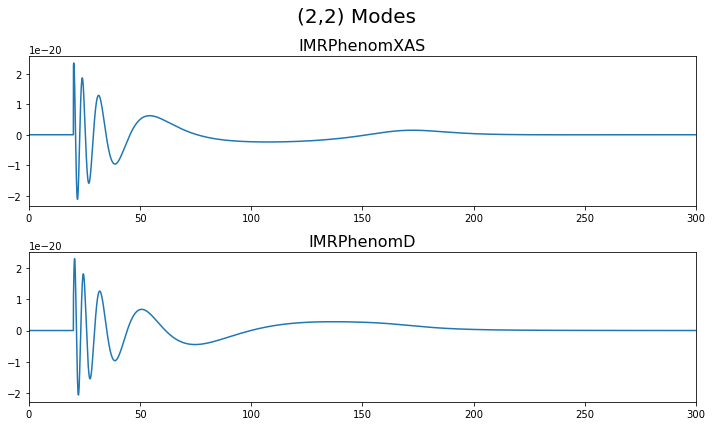

In [31]:
f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,6)) 
ax1.plot(freq_range, np.real(h_xas))
ax1.set_xlim(0, 300)
ax1.set_title('IMRPhenomXAS', fontsize=16)


ax2.plot(freq_range, np.real(h_d))
ax2.set_xlim(0, 300)
ax2.set_title('IMRPhenomD', fontsize=16)

plt.suptitle('(2,2) Modes', fontsize=20)

plt.tight_layout()
plt.show()

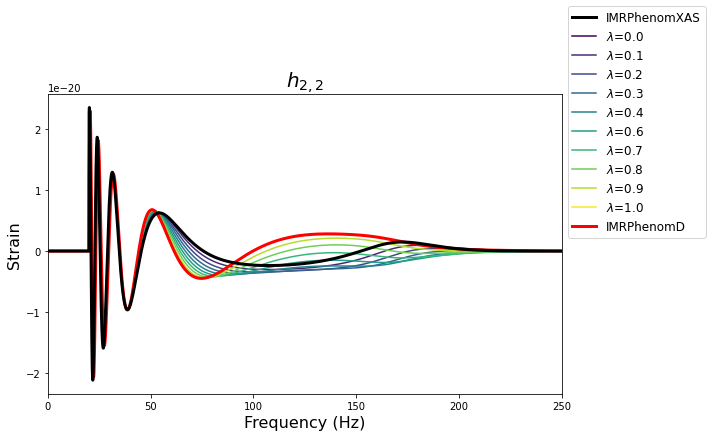

In [32]:
lam = 0.5


f, (ax)= plt.subplots(1, 1,  figsize=(10,6)) 

lams = np.linspace(0.0, 1.0, 10)
colors = plt.cm.viridis(lams)

lw=3

ax.plot(freq_range, np.real(h_xas), lw=lw, c='k', label='IMRPhenomXAS', zorder=10)

for i in range(len(lams)):
    h_hyb = get_hyb_wf(h_xas, h_d, lams[i])
    ax.plot(freq_range, h_hyb, color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    
ax.plot(freq_range, np.real(h_d), lw=lw, c='r', label='IMRPhenomD', zorder=9)


ax.set_xlim(0,250)
# ax.set_xlim(48, 50)
ax.set_title('$h_{2,2}$', fontsize=20)

plt.legend(fontsize=12, bbox_to_anchor=(1.0, .5))

plt.ylabel('Strain', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.tight_layout()
plt.show()

# Faithfulness (for  a given set of theta, phi, psi, iota, etc.)

In [33]:
def compute_faith(h1,h2,Sn):
    faith = inner_prod(h1, h2, Sn) / (np.sqrt(inner_prod(h1, h1, Sn)) * np.sqrt(inner_prod(h2, h2, Sn)))
    return faith

In [34]:
Sn = get_LIGO_psd(f_low,deltaF,int(f_max/deltaF))

In [35]:
N = 10
lams = np.linspace(0.0, 1.0, N)
faiths = np.zeros(N)

for i in range(N):
    h_hyb = get_hyb_wf(h_xas, h_d, lams[i])
    faiths[i] = compute_faith(h_xas, h_hyb, Sn)

print(faiths)


[1.         0.97175242 0.89204983 0.7749219  0.64008745 0.50840916
 0.39738196 0.31781261 0.27243594 0.25661796]


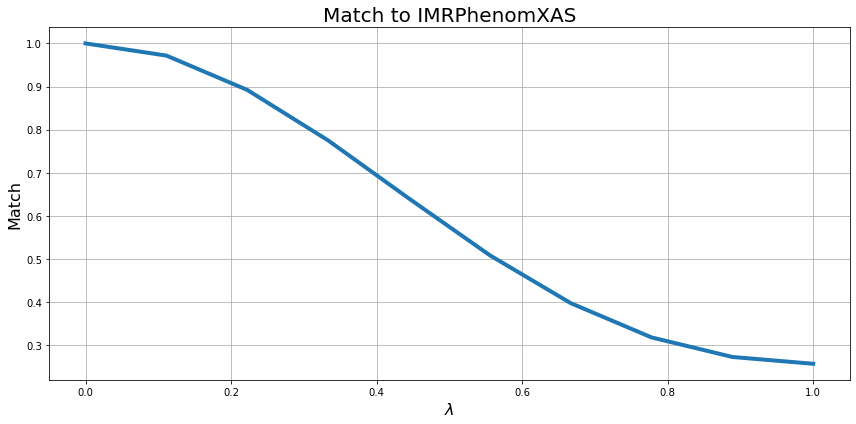

In [36]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(lams, faiths, lw=lw)

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

# Faithfulness (optimized over phase)

In [37]:
def compute_faith_opt(approx1, approx2, Sn, phi_opt_range, lam):
    faiths = np.zeros(len(phi_opt_range))
    hplus_1, hcross_1 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx1)
    h_1 = Fplus*hplus_1.data.data[:-1] + Fcross*hcross_1.data.data[:-1]

    for i, phi_opt in enumerate(phi_opt_range):
        hplus_2, hcross_2 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef+phi_opt, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx2)
        h_2 = Fplus*hplus_2.data.data[:-1] + Fcross*hcross_2.data.data[:-1]
        h_2 = -h_2 

        h_hyb = get_hyb_wf(h_1, h_2, lam)

        faiths[i] = inner_prod(h_1, h_hyb, Sn) / (np.sqrt(inner_prod(h_1, h_1, Sn)) * np.sqrt(inner_prod(h_hyb, h_hyb, Sn)))
    # print(faiths)
    return np.max(faiths)

In [38]:
approx1 = ls.IMRPhenomXAS
approx2 = ls.IMRPhenomD

N = 10
lams = np.linspace(0.0, 1.0, N)
faiths_opt = np.zeros(N)
phi_opt_range = np.linspace(0, np.pi, 20)

for i in range(N):
    faiths_opt[i] = compute_faith_opt(approx1, approx2, Sn, phi_opt_range, lams[i]) 

    

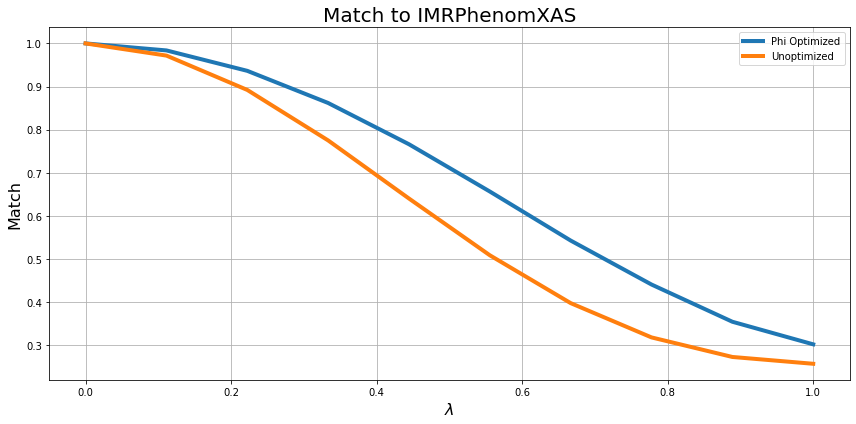

In [39]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(lams, faiths_opt, lw=lw, label='Phi Optimized')
plt.plot(lams, faiths, lw=lw, label='Unoptimized')

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Faithfulness (Optimized over t_c, phi)

In [40]:
def compute_faith_opt_opt(approx1, approx2, Sn, phi_opt_range, t_opt_range, lam, freq_range):
    faiths = np.zeros((len(phi_opt_range), len(t_opt_range)))

    hplus_1, hcross_1 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx1)
    h_1 = Fplus*hplus_1.data.data[:-1] + Fcross*hcross_1.data.data[:-1]

    for i, phi_opt in enumerate(phi_opt_range):
        # Generate second wavefunction with a phase shift (phi_opt)
        hplus_2, hcross_2 = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, iota, phiRef+phi_opt, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approx2)
        h_2 = Fplus*hplus_2.data.data[:-1] + Fcross*hcross_2.data.data[:-1]
        h_2 = -h_2 

        h_hyb = get_hyb_wf(h_1, h_2, lam)

        # Implement time shift
        for j, t_opt in enumerate(t_opt_range):
            h_hyb_TD_shift = np.fft.fft(h_hyb * np.exp(-2*np.pi*1j*freq_range*t_opt))
            h_hyb_FD_shift = np.fft.ifft(h_hyb_TD_shift)

            faiths[i,j] = inner_prod(h_1, h_hyb_FD_shift, Sn) / (np.sqrt(inner_prod(h_1, h_1, Sn)) * np.sqrt(inner_prod(h_hyb_FD_shift, h_hyb_FD_shift, Sn)))

        # print(faiths[i])  
    return np.max(faiths)

In [41]:
approx1 = ls.IMRPhenomXAS
approx2 = ls.IMRPhenomD

N = 10
lams = np.linspace(0.0, 1.0, N)
faiths_opt_opt = np.zeros(N)

phi_opt_range = np.linspace(0, np.pi, 10)
t_opt_range = np.linspace(0, 0.005, 10)

for i in range(N):
    faiths_opt_opt[i] = compute_faith_opt_opt(approx1, approx2, Sn, phi_opt_range, t_opt_range, lams[i], freq_range) 


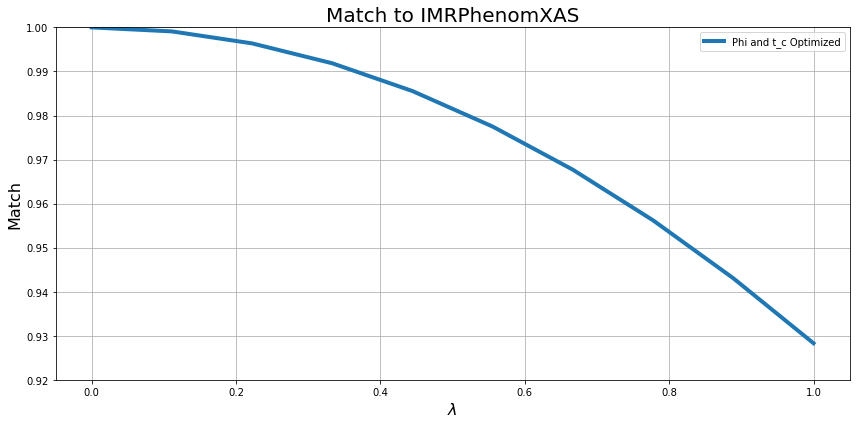

In [42]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
# plt.plot(lams, faiths, lw=lw, label='Unoptimized')
# plt.plot(lams, faiths_opt, lw=lw, label='Phi Optimized')
plt.plot(lams, faiths_opt_opt, lw=lw, label='Phi and t_c Optimized')

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)
plt.ylim(0.92, 1)
plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

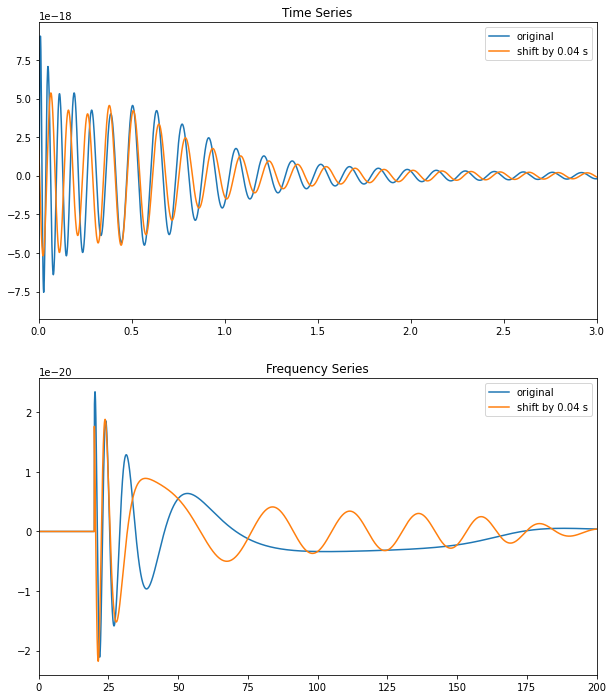

In [43]:
# Test time shift code
h_hyb = get_hyb_wf(h_xas, h_d, lam=0.2)
n=len(h_hyb)
zpfact=8

h_hyb_TD = np.fft.fft(h_hyb)
h_hyb_test = np.fft.ifft(h_hyb_TD)

dt = 0.04
h_hyb_TD_shift = np.fft.fft(h_hyb * np.exp(-2*np.pi*1j*freq_range*dt))
h_hyb_FD_shift = np.fft.ifft(h_hyb_TD_shift)

f, (ax1, ax2)= plt.subplots(2, 1,  figsize=(10,12)) 

t = np.linspace(0, 100, len(h_hyb_TD))
ax1.set_title("Time Series")
ax1.plot(t,h_hyb_TD, label="original")
ax1.plot(t,h_hyb_TD_shift, label=f"shift by {dt:.2f} s")
ax1.legend()
ax1.set_xlim(0,3)

ax2.set_title("Frequency Series")
ax2.plot(freq_range,h_hyb_test, label="original")
ax2.plot(freq_range,h_hyb_FD_shift, label=f"shift by {dt:.2f} s")
ax2.legend()
ax2.set_xlim(0,200)

plt.show()